<h1 style="text-align: center;">Multi-Sensor Fusion for Enhanced Object Detection and Tracking in Dynamic Environments</h1>

**Step 1: Set Up the Environment**

Install the required libraries if not already installed:<br>
*pip install opencv-python numpy matplotlib*

**Step 2: Load the Modules Required**

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import use

**Step 3: Set the backend to 'Agg' to avoid Tkinter dependency**

In [8]:
use('Agg')

**Step 4: Load the Haar Cascades for car and person detection**

In [9]:
car_cascade = cv2.CascadeClassifier('haarcascade_car.xml')
person_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_fullbody.xml')

**Step 5: Initialize the Kalman Filter for tracking**

In [10]:
kalman = cv2.KalmanFilter(4, 2)
kalman.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
kalman.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
kalman.processNoiseCov = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32) * 0.03

**Step 6: Load the provided video file**

In [11]:
cap = cv2.VideoCapture('./data/sample_video.mp4')

**Step 7: Get video properties**

In [12]:
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

**Step 8: Define the codec and create a VideoWriter object to save the output video**

In [13]:
output = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

**Step 9: Analysis of Video**

In [14]:
# Prepare arrays for plot
car_counts = []
person_counts = []
frames = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale for the cascade classifiers
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect cars and people in the frame
    cars = car_cascade.detectMultiScale(gray, 1.1, 3)
    people = person_cascade.detectMultiScale(gray, 1.1, 3)

    # Track detections
    car_counts.append(len(cars))
    person_counts.append(len(people))
    frames.append(len(frames))

    # Process detected cars and people
    for (x, y, w, h) in cars:
        measured = np.array([[np.float32(x + w / 2)], [np.float32(y + h / 2)]])
        kalman.correct(measured)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, "Car", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    for (x, y, w, h) in people:
        measured = np.array([[np.float32(x + w / 2)], [np.float32(y + h / 2)]])
        kalman.correct(measured)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(frame, "Person", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # Predict and draw the predicted location
    predicted = kalman.predict()
    predicted_center = (int(predicted[0]), int(predicted[1]))
    cv2.circle(frame, predicted_center, 5, (0, 0, 255), -1)
    cv2.putText(frame, "Predicted", predicted_center, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    
    # Write the frame to the output video
    output.write(frame)
    
    # Show the result
    cv2.imshow("Car and Person Detection and Tracking", frame)
    if cv2.waitKey(30) & 0xFF == 27:  # Press ESC to exit
        break

# Release resources
cap.release()
output.release()
cv2.destroyAllWindows()

C:\Users\sinch\AppData\Local\Temp\ipykernel_2932\3561401404.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_center = (int(predicted[0]), int(predicted[1]))


**Step 10: Plot after video processing**

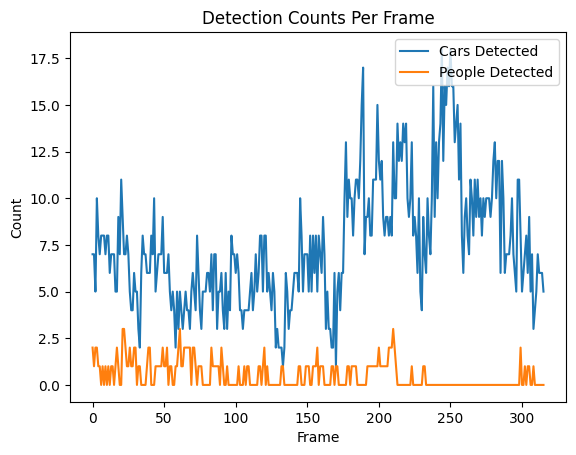

In [15]:
%matplotlib inline

plt.figure()
plt.plot(frames, car_counts, label='Cars Detected')
plt.plot(frames, person_counts, label='People Detected')
plt.xlabel('Frame')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title("Detection Counts Per Frame")
plt.show()  # Display the plot in the notebook